In [1]:
import tempfile, os, warnings, timeit
import pandas as pd
import numpy as np
from skimage import io
from flowdec import data as fd_data
from flowdec import psf as fd_psf
from flowdec import restoration as fd_restoration

DL2_PATH = os.path.join(os.path.expanduser('~'), 
    'repos', 'misc', 'DeconvolutionLab2', 'target', 'DeconcolutionLab2_-0.1.0-SNAPSHOT.jar')
N_ITER = 25 # Number of RL iterations

In [2]:
# Load PSF and data
#acq = fd_data.bars_25pct()
#acq = fd_data.load_bars()
acq = fd_data.load_microtubules()
acq.shape()

{'actual': (128, 256, 512), 'data': (128, 256, 512), 'kernel': (128, 256, 512)}

In [154]:
import imp
imp.reload(fd_data)
imp.reload(fd_restoration)

<module 'flowdec.restoration' from 'C:\\Users\\User\\repos\\flowdec\\python\\flowdec\\restoration.py'>

In [43]:
def run_flowdec(data, kernel, **kwargs):
    algo = fd_restoration.RichardsonLucyDeconvolver(data.ndim, **kwargs)
    acq = fd_data.Acquisition(data=data, kernel=kernel)
    return algo.initialize().run(acq, niter=N_ITER).data
    
def run_dl2(data, kernel, algo='RL {}'.format(N_ITER), exargs=''):
    # Generate temporary files to store image data within
    data_file   = tempfile.mktemp('.tif', 'data-')
    kernel_file = tempfile.mktemp('.tif', 'kernel-')
    output_file = tempfile.mktemp('', 'output-') 

    # Ignore low-contrast image warnings from skimage
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        io.imsave(data_file, acq.data)
        io.imsave(kernel_file, acq.kernel)

    os.path.basename(data_file), os.path.basename(kernel_file), os.path.basename(output_file)
    
    # Setup system call to execute DL2 CLI
    dl2_cmd = "java -Xmx32G -cp {jar} DeconvolutionLab2 Run -image file {data}"\
        " -psf file {psf} -algorithm {algo} {exargs} -out stack {output_file} -path {output_path}"\
        .format(
            jar=DL2_PATH, data=data_file, psf=kernel_file, algo=algo, exargs=exargs,
            output_file=os.path.basename(output_file), output_path=os.path.dirname(output_file)
        )
    !$dl2_cmd
    return io.imread(output_file + '.tif')

In [4]:
%%capture
res_dl1 = run_dl2(acq.data, acq.kernel, exargs='-constraint non')

In [5]:
%%capture
res_dl2 = run_dl2(acq.data, acq.kernel, exargs='-pad E2 E2 1,1 -constraint non')

In [50]:
%%capture
#res_dl3 = run_dl2(acq.data, acq.kernel, algo='RIF .1')
#res_dl3 = run_dl2(acq.data, acq.kernel, algo='NIF')
res_dl3 = run_dl2(acq.data, acq.kernel, algo='RLTV 10 0.1')

In [51]:
res_dl3.shape, res_dl3.dtype

((128, 256, 512), dtype('float32'))

In [7]:
res_fd1 = run_flowdec(acq.data, acq.kernel)
res_fd2 = run_flowdec(acq.data, acq.kernel, start_mode='input', pad_mode='none')
res_fd3 = run_flowdec(acq.data, acq.kernel, start_mode='input', pad_mode='log2', pad_min=[1,1,1], pad_fill='constant')

In [8]:
res_fd1.shape, res_fd1.dtype

((128, 256, 512), dtype('float32'))

In [9]:
acq.actual.shape, acq.actual.dtype

((128, 256, 512), dtype('float32'))

In [52]:
pd.concat([
    pd.Series(v.ravel()).describe(percentiles=[.05, .1, .25, .5, .75, .9, .95]).rename(k)
    for k, v in {
        'data': acq.data, 'actual': acq.actual, 
        'fd1': res_fd1, 'fd2': res_fd2, 'fd3': res_fd3, 
        'dl1': res_dl1, 'dl2': res_dl2, 'dl3': res_dl3
    }.items()
], axis=1)

,data,actual,fd1,fd2,fd3,dl1,dl2,dl3
count,1.677722e+07,1.677722e+07,1.677722e+07,1.677722e+07,1.677722e+07,1.677722e+07,1.677722e+07,1.677722e+07
mean,9.721270e+01,8.654011e+01,9.721268e+01,9.721271e+01,9.721254e+01,9.721272e+01,9.721266e+01,1.006150e+02
std,8.148482e+01,6.080412e+02,2.185103e+02,2.312834e+02,4.945266e+02,2.293803e+02,4.850738e+02,2.122092e+02
min,0.000000e+00,0.000000e+00,9.316542e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
5%,1.200000e+01,0.000000e+00,2.533535e+00,1.066487e+00,1.247905e-04,1.105496e+00,2.245257e-04,1.312133e+00
10%,2.000000e+01,0.000000e+00,3.745129e+00,2.228656e+00,5.088485e-04,2.294297e+00,8.641107e-04,3.081004e+00
25%,4.100000e+01,0.000000e+00,1.214297e+01,1.090744e+01,1.307979e-02,1.103406e+01,1.923849e-02,1.180591e+01
50%,7.700000e+01,0.000000e+00,3.077214e+01,2.993242e+01,7.834735e-01,3.030785e+01,9.507684e-01,3.811569e+01
75%,1.330000e+02,0.000000e+00,9.065487e+01,8.522858e+01,1.657648e+01,8.619962e+01,1.769036e+01,1.041858e+02
90%,1.930000e+02,0.000000e+00,2.259804e+02,2.243740e+02,1.385075e+02,2.242221e+02,1.430305e+02,2.344141e+02


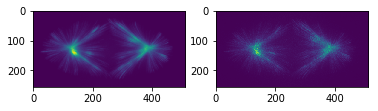

In [53]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2)
axs[0].imshow(res_fd2.max(axis=0))
axs[1].imshow(res_dl3.max(axis=0))

In [11]:
from skimage.measure import compare_ssim, compare_psnr, compare_nrmse, compare_mse
from skimage.exposure import rescale_intensity

score_fns = dict(
    ssim=compare_ssim,
    psnr=compare_psnr,
    nrmse=compare_nrmse,
    #mse=compare_mse
)

def to_uint16(img):
    return img.clip(0, 65535).astype(np.uint16)

def get_scores(img_true, img_pred):
    img_pred = to_uint16(img_pred)
    img_true = to_uint16(img_true)
    return pd.Series({k:fn(img_true, img_pred) for k, fn in score_fns.items()})

In [32]:
# Bars
df = pd.DataFrame({
    'Flowdec-Defaults': get_scores(acq.actual, res_fd1),
    'Flowdec-Matching': get_scores(acq.actual, res_fd2),
    'Flowdec-Paddings': get_scores(acq.actual, res_fd3),
    'DL2-Defaults': get_scores(acq.actual, res_dl1),
    'DL2-Paddings': get_scores(acq.actual, res_dl2)
})
df

,DL2-Defaults,DL2-Paddings,Flowdec-Defaults,Flowdec-Matching,Flowdec-Paddings
nrmse,3.210454,3.118773,3.439062,3.190914,3.100556
psnr,14.903372,15.155026,14.305900,14.956398,15.205908
ssim,0.709299,0.789698,0.690510,0.716500,0.792731


In [54]:
# Microtubules
df = pd.DataFrame({
    'Flowdec-Defaults': get_scores(acq.actual, res_fd1),
    'Flowdec-Matching': get_scores(acq.actual, res_fd2),
    'Flowdec-Paddings': get_scores(acq.actual, res_fd3),
    'DL2-Defaults': get_scores(acq.actual, res_dl1),
    'DL2-Paddings': get_scores(acq.actual, res_dl2),
    'DL2-RIF': get_scores(acq.actual, res_dl3)
})
df

,DL2-Defaults,DL2-Paddings,DL2-RIF,Flowdec-Defaults,Flowdec-Matching,Flowdec-Paddings
nrmse,0.848344,0.983676,0.885446,0.871985,0.846733,0.993933
psnr,41.993272,40.707667,41.621462,41.754527,42.009780,40.617565
ssim,0.939489,0.928242,0.932685,0.936005,0.939780,0.927768
